In [1]:
import gzip
import sklearn
from collections import defaultdict
import random
import math
import numpy as np
from sklearn.metrics import jaccard_score as jaccard
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import scipy.optimize
import string
from nltk.stem.porter import *
from scipy.sparse import lil_matrix
# from sklearn.linear_model import LogisticRegressionCV
# from sklearn.model_selection import GridSearchCV


In [2]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:    
        yield json.loads(l)

In [3]:
data = list(parse("data/Video_Games_5.json.gz"))

In [4]:
data[0]

{'overall': 5.0,
 'verified': True,
 'reviewTime': '10 17, 2015',
 'reviewerID': 'A1HP7NVNPFMA4N',
 'asin': '0700026657',
 'reviewerName': 'Ambrosia075',
 'reviewText': "This game is a bit hard to get the hang of, but when you do it's great.",
 'summary': "but when you do it's great.",
 'unixReviewTime': 1445040000}

In [5]:
df = pd.DataFrame(data)

In [67]:
df[df['overall'].isnull()]

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,length_summary,length_review,date,year,month


In [6]:
col_data = ["rating of the product","boolean","time of the review (raw)","ID of reviewer",\
            "ID of product", "name of reviewer", "text of review", "summary of review",\
            "time of review (unix time)", "# of helpful votes of review", "dictionary of product metadata",\
            "image that users post after receiving product"]
col_df = pd.DataFrame({'feature':df.columns, 'description':col_data})
col_df.index +=1
col_df

,feature,description
1,overall,rating of the product
2,verified,boolean
3,reviewTime,time of the review (raw)
4,reviewerID,ID of reviewer
5,asin,ID of product
6,reviewerName,name of reviewer
7,reviewText,text of review
8,summary,summary of review
9,unixReviewTime,time of review (unix time)
10,vote,# of helpful votes of review


In [12]:
df['length_summary'] = df['summary'].str.len()
df['length_review'] = df['reviewText'].str.len()
df['vote'] = df['vote'].fillna(0)
df['vote'] = df['vote'].str.replace(',', '')
df['vote'] = df['vote'].astype(np.float)

In [32]:
df['overall'] = df['overall'].astype(np.int)

In [33]:
df.describe()

,overall,unixReviewTime,vote,length_summary,length_review
count,497577.000000,4.975770e+05,107793.000000,497468.000000,497419.000000
mean,4.220456,1.367848e+09,10.655117,24.494878,670.288642
std,1.185424,1.224113e+08,35.582078,18.895582,1266.122219
min,1.000000,9.398592e+08,2.000000,1.000000,1.000000
25%,4.000000,1.316563e+09,2.000000,10.000000,57.000000
50%,5.000000,1.410221e+09,4.000000,18.000000,210.000000
75%,5.000000,1.452384e+09,8.000000,34.000000,710.000000
max,5.000000,1.538438e+09,2474.000000,282.000000,32721.000000


In [75]:
#averages grouped by overall rating
df.groupby(['overall']).mean()

,verified,unixReviewTime,vote,length_summary,length_review,year,month
overall,,,,,,,
1,0.492245,1.362514e+09,11.077242,28.189208,666.599825,2012.671567,6.586731
2,0.502175,1.340700e+09,9.339250,29.853916,1010.199851,2011.982888,6.555086
3,0.569283,1.342521e+09,10.363313,29.063202,1021.972914,2012.050279,6.441969
4,0.586051,1.338882e+09,10.460509,27.495467,981.969064,2011.931888,6.476904
5,0.742126,1.383786e+09,10.956679,21.995902,488.200028,2013.361350,6.402310


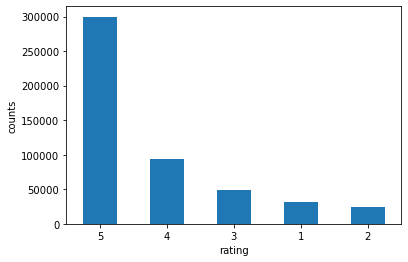

In [31]:
df['overall'].value_counts().plot(kind='bar')
plt.xticks(rotation='horizontal')
plt.xlabel('rating')
plt.ylabel('counts')
plt.title("")
plt.show()

In [125]:
df['overall'].value_counts() / len(df['overall'])

5    0.602437
4    0.188220
3    0.098771
1    0.062067
2    0.048505
Name: overall, dtype: float64

In [34]:
df['date'] = pd.to_datetime(df['unixReviewTime'],unit='s').dt.year

In [36]:
df['year'] = pd.to_datetime(df['unixReviewTime'],unit='s').dt.year

In [40]:
df['month'] = pd.to_datetime(df['unixReviewTime'],unit='s').dt.month

In [76]:
df['day'] = pd.to_datetime(df['unixReviewTime'],unit='s').dt.day

In [92]:
gpy = df.groupby(['year']).mean()
gpy

,overall,verified,unixReviewTime,vote,length_summary,length_review,month,day
year,,,,,,,,
1999,4.259259,0.049383,9.443701e+08,13.194030,27.469136,669.617284,11.629630,16.333333
2000,4.066703,0.027434,9.681821e+08,12.821486,28.894567,1118.973104,8.658419,16.646046
2001,4.101384,0.029050,9.965364e+08,8.530015,28.398323,1102.848314,7.471437,15.891792
2002,4.096708,0.037949,1.026167e+09,9.159825,28.987347,1172.502176,6.754625,15.679679
2003,4.060151,0.040291,1.057484e+09,9.901396,28.077165,1334.638234,6.662666,15.979997
2004,4.002760,0.029805,1.089151e+09,11.613401,28.762660,1415.148475,6.691183,15.726232
2005,4.001798,0.041608,1.121104e+09,11.850297,29.179168,1596.053551,6.850905,15.562733
2006,3.881760,0.069979,1.152165e+09,13.402563,30.116570,1704.043293,6.662030,15.811214
2007,3.989403,0.181384,1.184409e+09,13.774612,28.524105,1311.494511,6.932506,15.760668


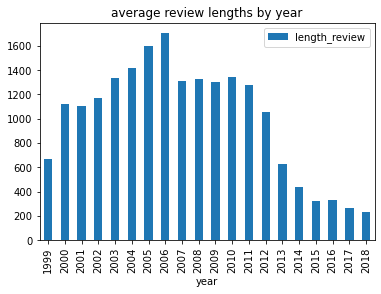

In [113]:
gpy.plot.bar(y='length_review', rot=90)
plt.title('average review lengths by year')
plt.show()

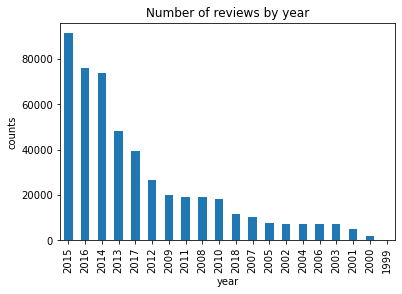

In [45]:
df['year'].value_counts().plot(kind='bar')
plt.xticks(rotation='vertical')
plt.xlabel('year')
plt.ylabel('counts')
plt.title('Number of reviews by year')
plt.show()

In [119]:
48241+\
73797+\
91340+\
75891+\
39199

328468

In [122]:
1859+\
5129+\
7352+\
6999+\
7247+\
7787+\
7045+\
10475+\
19131+\
19926+\
18386+\
19307+\
26571

157214

In [118]:
df.groupby(['year']).apply(len)

year
1999       81
2000     1859
2001     5129
2002     7352
2003     6999
2004     7247
2005     7787
2006     7045
2007    10475
2008    19131
2009    19926
2010    18386
2011    19307
2012    26571
2013    48241
2014    73797
2015    91340
2016    75891
2017    39199
2018    11814
dtype: int64

In [81]:
df.groupby(['month']).mean()

,overall,verified,unixReviewTime,vote,length_summary,length_review,year,day
month,,,,,,,,
1,4.269490,0.716484,1.370137e+09,7.781489,23.701829,581.638566,2013.378495,15.182033
2,4.258376,0.722405,1.375510e+09,9.566435,23.665868,606.043543,2013.464616,14.935012
3,4.219925,0.693622,1.373275e+09,9.851286,24.404756,683.695903,2013.314325,15.704543
4,4.223873,0.685542,1.369976e+09,9.276168,24.522110,660.568528,2013.126392,15.163969
5,4.194795,0.670530,1.368269e+09,10.367647,24.371648,701.917730,2012.988003,15.934924
6,4.174284,0.638800,1.361108e+09,10.505869,24.775503,720.429922,2012.677391,15.512531
7,4.236458,0.657808,1.365299e+09,9.038606,24.377455,631.016237,2012.726772,16.006735
8,4.245165,0.669499,1.374679e+09,10.177927,24.254691,628.276071,2012.939599,15.835396
9,4.215108,0.643364,1.368476e+09,12.372610,24.342937,679.007791,2012.659335,15.410995


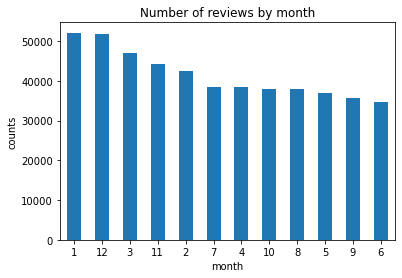

In [47]:
df['month'].value_counts().plot(kind='bar')
plt.xticks(rotation='horizontal')
plt.xlabel('month')
plt.ylabel('counts')
plt.title('Number of reviews by month')
plt.show()

In [84]:
# df.groupby(['length_review']).mean()

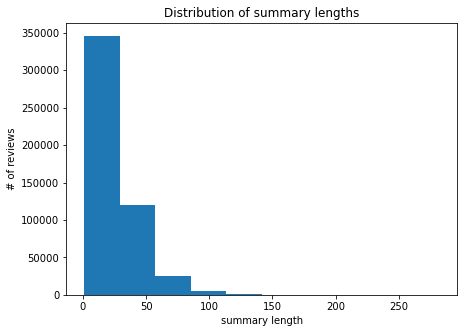

In [130]:
plt.figure(figsize = (7,5))
plt.hist(df['length_summary'])
plt.xlabel('summary length')
plt.ylabel('# of reviews')
plt.title('Distribution of summary lengths')
plt.show()

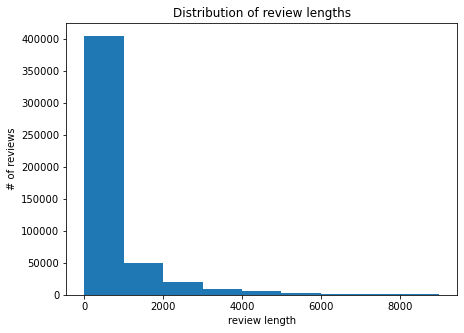

In [131]:
plt.figure(figsize = (7,5))
plt.hist(df['length_review'], bins = np.arange(0,10000,1000))
plt.xlabel('review length')
plt.ylabel('# of reviews')
plt.title('Distribution of review lengths')
plt.show()

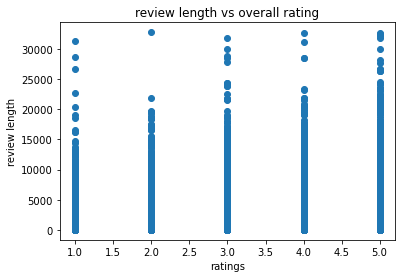

In [61]:
plt.scatter(df['overall'], df['length_review'])
plt.xlabel('ratings')
plt.ylabel('review length')
plt.title('review length vs overall rating')
plt.show()

In [5]:
X = [d for d in data]
y = [d['overall'] for d in data]

In [6]:
#shuffle data
Xy = list(zip(X,y))
random.shuffle(Xy)
X = np.array([d[0] for d in Xy])
y = np.array([d[1] for d in Xy])

In [ ]:
# df['len_rev'] = df['reviewText'].str.len()

In [ ]:
# data[0]

In [ ]:
# df.groupby(['revie÷werID']).size()
# ['overall'].value_counts()

In [ ]:
# df[df['reviewerID'].isnull()]

In [ ]:
447819 + 49758

In [ ]:
len(data)*.90

In [ ]:
len(data)*.10

In [ ]:
N = len(data)
N

In [ ]:
Xtrain = X[:447819]
Xvalid = X[447819:]
# Xtest = X[40000:50000]

ytrain = y[:447819]
yvalid = y[447819:]
# ytest = y[40000:50000]

In [7]:
Xtrain = X[:50000]
Xvalid = X[50000:60000]
# Xtest = X[40000:50000]

ytrain = y[:50000]
yvalid = y[50000:60000]

In [8]:
C = [.01, .1, 1, 10, 100]

In [52]:
#most common words in 'summary'
unigramsSumm = defaultdict(int)
for d in Xtrain:
    #not all data has a review
    if 'summary' in d:
#     token = nltk.word_tokenize(d['text'])
#     unigram = list(ngrams(token, 1))
        t = d['summary']
        text = " ".join(t.splitlines())
        unigram = text.strip().split()
        for u in unigram:
            unigramsSumm[u] += 1

#50 most common from training set, summary
mostCommonUniSumm =sorted(unigramsSumm.items(),key=lambda v: v[1],reverse=True)[:50]
unigram_wordsSumm = [u[0] for u in mostCommonUniSumm]
unigramIdSumm = dict(zip(unigram_wordsSumm, np.arange(5000,5051)))
unigramSetSumm = set(unigram_wordsSumm)

In [10]:
#summary
docFreqSumm = defaultdict(set)
for d in Xtrain:
    if 'summary' in d: 
        t = d['summary']
        text = " ".join(t.splitlines())
        unigramSumm = text.strip().split()
        for u in unigramSumm:
            docFreqSumm[u].add(d['reviewerID'])

#term freq
tfSumm = unigramsSumm

In [38]:
data[0]

{'overall': 5.0,
 'verified': True,
 'reviewTime': '10 17, 2015',
 'reviewerID': 'A1HP7NVNPFMA4N',
 'asin': '0700026657',
 'reviewerName': 'Ambrosia075',
 'reviewText': "This game is a bit hard to get the hang of, but when you do it's great.",
 'summary': "but when you do it's great.",
 'unixReviewTime': 1445040000}

In [54]:
Xtrain_4_ = [feature_uni_nopunc_wc_withSumm(d) for d in Xtrain]
Xvalid_4_ = [feature_uni_nopunc_wc_withSumm(d) for d in Xvalid]

In [58]:
Xtrain_4_ = lil_matrix(Xtrain_4_)
Xvalid_4_ = lil_matrix(Xvalid_4_)

In [59]:
#acc for dict size of 5000, BoW reviews + BoW summaries + review length
#0.6768
clf = LogisticRegression(C = 0.1, fit_intercept=False, max_iter = 50000) 
clf.fit(Xtrain_4_, ytrain)
#         theta = clf.coef_
predictions = clf.predict(Xvalid_4_)
correct = predictions == yvalid
acc = sum(correct) / len(correct)
print(acc)

0.6768


In [50]:
#Unigrams, keep punc, tfidf
#training data
unigrams = defaultdict(int)
for d in Xtrain:
    #not all data has a review
    if 'reviewText' in d:
#     token = nltk.word_tokenize(d['text'])
#     unigram = list(ngrams(token, 1))
        t = d['reviewText']
        text = " ".join(t.splitlines())
        unigram = text.strip().split()
        for u in unigram:
            unigrams[u] += 1

#1000 most common from training set, review text
mostCommonUni =sorted(unigrams.items(),key=lambda v: v[1],reverse=True)[:5000]
unigram_words = [u[0] for u in mostCommonUni]
unigramId = dict(zip(unigram_words, range(len(unigram_words))))
unigramSet = set(unigram_words)

In [51]:
#docFreq and tf
#training data
docFreq = defaultdict(set)
for d in Xtrain:
    if 'reviewText' in d: 
        t = d['reviewText']
        text = " ".join(t.splitlines())
        unigram = text.strip().split()
        for u in unigram:
            docFreq[u].add(d['reviewerID'])

#term freq
tf = unigrams


In [ ]:
#features including summaries
def feature_uni_nopunc_wc_withSumm(datum):
    feat = [0]*(len(unigramSet)+len(unigramSetSumm) + 1)
    if 'reviewText' in datum: 
        t = datum['reviewText']
        t = ''.join([c for c in t.lower() if not c in punctuation])

        text = " ".join(t.splitlines())
        unigram_words = text.strip().split()
    #     token = nltk.word_tokenize(t)
    #     unigram_words = list(ngrams(token, 1))
        for u in unigram_words:
            if not (u in unigramSet): continue
            feat[unigramId[u]] += 1
            
    if 'summary' in datum: 
        t = datum['summary']
        t = ''.join([c for c in t.lower() if not c in punctuation])

        text = " ".join(t.splitlines())
        unigram_wordsSumm = text.strip().split()
    #     token = nltk.word_tokenize(t)
    #     unigram_words = list(ngrams(token, 1))
        for u in unigram_wordsSumm:
            if not (u in unigramSetSumm): continue
            feat[unigramIdSumm[u]] += 1
        
        
    if 'reviewText' in datum:
        feat[-1] = len(datum['reviewText'])

    feat.append(1)
    return feat

In [ ]:
Xtrain_4_ = [feature_uni_nopunc_wc_withSumm(d) for d in Xtrain]
Xvalid_4_ = [feature_uni_nopunc_wc_withSumm(d) for d in Xvalid]

In [ ]:
# def feature_uni_punc_tfidf(datum):
#     feat = [0]*len(unigramSet)
#     if 'reviewText' in datum: 
#         t = datum['reviewText']
#         text = " ".join(t.splitlines())
#         unigram_words = text.strip().split()
    
#         for u in unigram_words:
#             if not (u in unigramSet): continue
#             tf_idf_word = np.log(len(Xtrain)/ len(docFreq[u])) * tf[u]
#             feat[unigramId[u]] = tf_idf_word

#     feat.append(1)
#     return feat

In [ ]:
# Xtrain_1 = [feature_uni_punc_tfidf(d) for d in Xtrain]
# Xvalid_1 = [feature_uni_punc_tfidf(d) for d in Xvalid]

In [32]:
punctuation = set(string.punctuation)

In [ ]:
#unigrams, discard punc, tfidf
# def feature_uni_nopunc_tfidf(datum):
#     feat = [0]*len(unigramSet)
#     if 'reviewText' in datum:
#         t = datum['reviewText']
#         t = ''.join([c for c in t.lower() if not c in punctuation])

#         text = " ".join(t.splitlines())
#         unigram_words = text.strip().split()
#     #     token = nltk.word_tokenize(t)
#     #     unigram_words = list(ngrams(token, 1))

#         for u in unigram_words:
#             if not (u in unigramSet): continue
#             tf_idf_word = np.log(len(Xtrain)/ len(docFreq[u])) * tf[u]
#             feat[unigramId[u]] = tf_idf_word

#     feat.append(1)
#     return feat

In [ ]:
# Xtrain_2 = [feature_uni_nopunc_tfidf(d) for d in Xtrain]
# Xvalid_2 = [feature_uni_nopunc_tfidf(d) for d in Xvalid]

In [ ]:
# #unigrams, keep punc, counts
# def feature_uni_punc_wc(datum):
#     feat = [0]*len(unigramSet)
#     if 'reviewText' in datum: 
#         t = datum['reviewText']
#     #     token = nltk.word_tokenize(t)
#     #     unigram_words = list(ngrams(token, 1))
#         text = " ".join(t.splitlines())
#         unigram_words = text.strip().split()

#         for u in unigram_words:
#             if not (u in unigramSet): continue
#             feat[unigramId[u]] += 1

#     feat.append(1)
#     return feat

In [ ]:
# Xtrain_3 = [feature_uni_punc_wc(d) for d in Xtrain]
# Xvalid_3 = [feature_uni_punc_wc(d) for d in Xvalid]

In [ ]:
#unigrams, discard punc, counts
def feature_uni_nopunc_wc(datum):
    feat = [0]*len(unigramSet)
    if 'reviewText' in datum: 
        t = datum['reviewText']
        t = ''.join([c for c in t.lower() if not c in punctuation])

        text = " ".join(t.splitlines())
        unigram_words = text.strip().split()
    #     token = nltk.word_tokenize(t)
    #     unigram_words = list(ngrams(token, 1))
        for u in unigram_words:
            if not (u in unigramSet): continue
            feat[unigramId[u]] += 1

    feat.append(1)
    return feat

In [ ]:
Xtrain_4 = [feature_uni_nopunc_wc(d) for d in Xtrain]
Xvalid_4 = [feature_uni_nopunc_wc(d) for d in Xvalid]

In [48]:
Xtrain_4_ = lil_matrix(Xtrain_4_)
Xvalid_4_ = lil_matrix(Xvalid_4_)

In [49]:
#acc for dict size 1000, reviews + summaries + review length
#.654
clf = LogisticRegression(C = 0.1, fit_intercept=False, max_iter = 50000) 
clf.fit(Xtrain_4_, ytrain)
#         theta = clf.coef_
predictions = clf.predict(Xvalid_4_)
correct = predictions == yvalid
acc = sum(correct) / len(correct)
print(acc)

0.654


In [ ]:
# #start of bigram models
# bigrams = defaultdict(int)

# for d in Xtrain:
# #     token = nltk.word_tokenize(d['text'])
# #     bigram = list(ngrams(token, 2)) 
#     if 'reviewText' in d: 
#         text = " ".join(d['reviewText'].splitlines())
#         bigram = [b for b in zip(text.split(" ")[:-1], text.split(" ")[1:])]
#         for b in bigram:
#             bigrams[b] += 1
        
# #1000 most common from training set
# mostCommonBi =sorted(bigrams.items(),key=lambda v: v[1],reverse=True)[:1000]
# bigram_words = [u[0] for u in mostCommonBi]
# bigramId = dict(zip(bigram_words, range(len(bigram_words))))
# bigramSet = set(bigram_words)

In [ ]:
#docFreq and tf
#training data
# docFreq = defaultdict(set)
# for d in Xtrain:
# #     token = nltk.word_tokenize(d['text'])
# #     bigram = list(ngrams(token, 2)) 
#     if 'reviewText' in d: 
#         text = " ".join(d['reviewText'].splitlines())
#         bigram = [b for b in zip(text.split(" ")[:-1], text.split(" ")[1:])]
#         for b in bigram:
#             docFreq[b].add(d['reviewerID'])

# #term freq
# tf = bigrams

In [ ]:
# #bigrams, keep punc, tfidf
# def feature_bi_punc_tfidf(datum):
#     feat = [0]*len(bigramSet)
#     if 'reviewText' in datum: 
#         t = datum['reviewText']
#     #     token = nltk.word_tokenize(t)
#     #     bigram_words = list(ngrams(token, 2))
#         text = " ".join(t.splitlines())
#         bigram_words = [b for b in zip(text.split(" ")[:-1], text.split(" ")[1:])]

#         for b in bigram_words:
#             if not (b in bigramSet): continue
#             tf_idf_word = np.log(len(Xtrain)/ len(docFreq[b])) * tf[b]
#             feat[bigramId[b]] = tf_idf_word

#     feat.append(1)
#     return feat

In [ ]:
# Xtrain_5 = [feature_bi_punc_tfidf(d) for d in Xtrain]
# Xvalid_5 = [feature_bi_punc_tfidf(d) for d in Xvalid]

In [ ]:
# #bigrams, discard punc, tfidf
# def feature_bi_nopunc_tfidf(datum):
#     feat = [0]*len(bigramSet)
#     if 'reviewText' in datum: 
#         t = datum['reviewText']
#     #     token = nltk.word_tokenize(t)
#     #     bigram_words = list(ngrams(token, 2))
#         t = ''.join([c for c in t.lower() if not c in punctuation])
#         text = " ".join(t.splitlines())
#         bigram_words = [b for b in zip(text.split(" ")[:-1], text.split(" ")[1:])]

#         for b in bigram_words:
#             if not (b in bigramSet): continue
#             tf_idf_word = np.log(len(Xtrain)/ len(docFreq[b])) * tf[b]
#             feat[bigramId[b]] = tf_idf_word

#     feat.append(1)
#     return feat

In [ ]:
# Xtrain_6 = [feature_bi_nopunc_tfidf(d) for d in Xtrain]
# Xvalid_6 = [feature_bi_nopunc_tfidf(d) for d in Xvalid]

In [ ]:
# #bigrams, keep punc, counts
# def feature_bi_punc_wc(datum):
#     feat = [0]*len(bigramSet)
#     if 'reviewText' in datum: 
#         t = datum['reviewText']

#     #     token = nltk.word_tokenize(t)
#     #     bigram_words = list(ngrams(token, 2))
#         text = " ".join(t.splitlines())
#         bigram_words = [b for b in zip(text.split(" ")[:-1], text.split(" ")[1:])]

#         for b in bigram_words:
#             if not (b in bigramSet): continue
#             feat[bigramId[b]] += 1

#     feat.append(1)
#     return feat

In [ ]:
# Xtrain_7 = [feature_bi_punc_wc(d) for d in Xtrain]
# Xvalid_7 = [feature_bi_punc_wc(d) for d in Xvalid]

In [ ]:
#bigrams, discard punc, counts
# def feature_bi_nopunc_wc(datum):
#     feat = [0]*len(bigramSet)
#     if 'reviewText' in datum: 
#         t = datum['reviewText']

#     #     token = nltk.word_tokenize(t)
#     #     bigram_words = list(ngrams(token, 2))

#         t = ''.join([c for c in t.lower() if not c in punctuation])
#         text = " ".join(t.splitlines())
#         bigram_words = [b for b in zip(text.split(" ")[:-1], text.split(" ")[1:])]

#         for b in bigram_words:
#             if not (b in bigramSet): continue
#             feat[bigramId[b]] += 1

#     feat.append(1)
#     return feat

In [ ]:
# Xtrain_8 = [feature_bi_nopunc_wc(d) for d in Xtrain]
# Xvalid_8 = [feature_bi_nopunc_wc(d) for d in Xvalid]

In [ ]:
from tqdm import tqdm

In [ ]:
len(ytrain)

In [ ]:
# to_fit = [lil_matrix(Xtrain_1), lil_matrix(Xtrain_2), lil_matrix(Xtrain_3), lil_matrix(Xtrain_4), lil_matrix(Xtrain_5), lil_matrix(Xtrain_6), lil_matrix(Xtrain_7), lil_matrix(Xtrain_8)]
# to_fit = [lil_matrix(Xtrain_5), lil_matrix(Xtrain_6), lil_matrix(Xtrain_7), lil_matrix(Xtrain_8)]

# to_pred = [Xvalid_1, Xvalid_2, Xvalid_3, Xvalid_4, Xvalid_5, Xvalid_6, Xvalid_7, Xvalid_8]
# to_pred = [Xvalid_5, Xvalid_6, Xvalid_7, Xvalid_8]



In [ ]:
# pipeline
# model_performances = []
# for i in tqdm(range(len(to_fit))):
#     for c in C:
#         clf = LogisticRegression(C = c, fit_intercept=False, max_iter = 500000) 
#         clf.fit(to_fit[i], ytrain)
# #         theta = clf.coef_
#         predictions = clf.predict(to_pred[i])
#         correct = predictions == yvalid
#         acc = sum(correct) / len(correct)
#         print(str(i) + "      " + str(c) + "      "+str(acc))
#         model_performances.append(acc)

In [ ]:
# model_names = ["unigrams, keep punc, tfidf",
# "unigrams, discard punc, tfidf",
# "unigrams, keep punc, counts",
# "unigrams, discard punc, counts",
# "bigrams, keep punc, tfidf",
# "bigrams, discard punc, tfidf",
# "bigrams, keep punc, counts",
# "bigrams, discard punc, counts"]

# index_names = []
# for model in model_names:
#     for c in C:
#         index_names.append((model,c))

In [ ]:
# index = pd.MultiIndex.from_tuples(index_names, names=['model','regularization param'])

In [ ]:
# df = pd.DataFrame(data = model_performances, index = index, columns = ['mse'])
# df

In [ ]:
# df.sort_values(by = 'mse', ascending =False).iloc[0]
# Xtrain_4 = lil_matrix(Xtrain_4)
# Xvalid_4 = lil_matrix(Xvalid_4)

In [ ]:
#acc for just reviews
#0.6482173720808714
# clf = LogisticRegression(C = 0.1, fit_intercept=False, max_iter = 50000) 
# clf.fit(Xtrain_4, ytrain)
# #         theta = clf.coef_
# predictions = clf.predict(Xvalid_4)
# correct = predictions == yvalid
# acc = sum(correct) / len(correct)
# print(acc)

In [ ]:
# len([d for d in Xvalid if d['overall'] == 5]) / len(Xvalid)

In [ ]:
Xtrain_4_ = lil_matrix(Xtrain_4_)
Xvalid_4_ = lil_matrix(Xvalid_4_)

In [ ]:
#acc for reviews + review summaries
#0.6509506009083966
clf = LogisticRegression(C = 0.1, fit_intercept=False, max_iter = 50000) 
clf.fit(Xtrain_4_, ytrain)
#         theta = clf.coef_
predictions = clf.predict(Xvalid_4_)
correct = predictions == yvalid
acc = sum(correct) / len(correct)
print(acc)

In [ ]:
# clf = LogisticRegressionCV(cv=5, random_state=0,fit_intercept=False, max_iter = 10000).fit(Xtrain_4_, ytrain)
# predictions = clf.predict(Xvalid_4_)
# correct = predictions == yvalid
# acc = sum(correct) / len(correct)
# print(acc)

In [ ]:

# import numpy 
# import math
# from scipy.stats import uniform
# import matplotlib.pyplot as plt 
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.linear_model import LogisticRegression

# def gridRandomCV(X_train_vect, X_test_vect, c_max, title_cf=''):
    
#     # empty list that will hold cv scores
#     cv_scores = []
    
#     # Create regularization penalty space
#     penalty = ['l1', 'l2']

#     # Create regularization hyperparameter distribution using uniform distribution
#     # This distribution is constant between loc and loc + scale.
#     C = uniform(loc=0, scale=c_max)
    
#     # Create hyperparameter options
#     hyperparameters = dict(C=C, penalty=penalty)

#     ###################################################################
#     # Cross Validation using RandomizedSearchCV
#     # Create randomized search 10-fold cross validation and 100 iterations
#     model = RandomizedSearchCV(LogisticRegression(), hyperparameters, 
#                     random_state=1, n_iter=100, cv=10, verbose=0, n_jobs=-1)
    
#     # Fit randomized search
#     best_model = model.fit(X_train_vect, ytrain)
    
#     best_regularizer = best_model.best_estimator_.get_params()['penalty']
    
#     # View best hyperparameters
#     print(bold + '\nBest Penalty:', best_regularizer)
    
#     optimal_lambda_rcv = best_model.best_estimator_.get_params()['C']
#     print('RandomizedSearchCV: Best C:', optimal_lambda_rcv, end, '\n')
    
#     means = best_model.cv_results_['mean_test_score']
#     stds = best_model.cv_results_['std_test_score']
#     print ("Mean Test Score (+/-) Standard Deviation for Parameters: ")
#     for mean, std, params in zip(
#             means, stds, best_model.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))
    
#     print('\nThe optimal value of lambda using RandomizedSearchCV is %f.' 
#                                                   % (1/optimal_lambda_rcv))
    
#     compute_metrics(best_model, X_test_vect, 
#                         title_cf="Confusion Matrix: RandomizedSearchCV")
#     ###################################################################


#     ###################################################################
#     # Cross Validation using GridSearchCV
#     inv_lambda_values = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 
#                            10**0, 10**1, 10**2, 10**3, 10**4, 10**5]
    
#     tuned_parameters = [{'C': inv_lambda_values}, {'penalty': penalty}]
    
#     model = GridSearchCV(LogisticRegression(), 
#                          tuned_parameters, scoring = 'f1', cv=10)
#     model.fit(X_train_vect, ytrain)

#     means = model.cv_results_['mean_test_score']
# #     stds = model.cv_results_['std_test_score']
# #     for mean, std, params in zip(means, stds, model.cv_results_['params']):
# #         print("%0.3f (+/-%0.03f) for %r"
# #               % (mean, std * 2, params))
# #     print(type(model.cv_results_['params']))
# #     print(model.cv_results_['params'])
    
#     # determining best lambda
#     optimal_lambda_gcv = model.cv_results_['params'][means.argmax()].get('C')
#     print('\nGridSearchCV: Best C:', optimal_lambda_gcv)
#     print(
#         '\nThe optimal value of lambda using GridSearchCV is %f.' 
#                                                     % (1/optimal_lambda_gcv))
    
#     compute_metrics(model, X_test_vect, title_cf="Confusion Matrix: GridSearchCV")
#     ###################################################################
    
#     return optimal_lambda_rcv, best_regularizer



In [ ]:
# optimal_lambda, best_regularizer = gridRandomCV(Xtrain_4_, Xvalid_4_, 4)